In [4]:
# Movie Reviews

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

In [3]:
# Function for feature building and extraction on natural language data

In [115]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    movie_data = pd.read_csv(fn, sep='\t')
    print("movie_data is:", type(movie_data))
    print("movie_data has", movie_data.shape[0], "rows and", movie_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in movie_data:")
    print(movie_data.dtypes, "\n")
    print("the first 10 rows in movie_data:")
    print(movie_data.head(5))
    if (not test):
        print("The rate of 'good' movie reviews in the dataset: ")
        print(movie_data['sentiment'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, stop_words={'crazy'}, alternate_sign=False)
        X_hv = hv.fit_transform(movie_data.review)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(movie_data.review)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    movie_data['word_count'] = movie_data['review'].str.split(' ').str.len()
    movie_data['punc_count'] = movie_data['review'].str.count("\.")

    X_quant_features = movie_data[["word_count", "punc_count"]]
#     X_quant_features = movie_data[["word_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = movie_data['sentiment']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(movie_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, movie_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

In [116]:
# Create Training Data

In [117]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='./data/moviereviews_train.tsv', my_random_seed=13)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

movie_data is: <class 'pandas.core.frame.DataFrame'>
movie_data has 25000 rows and 3 columns 

the data types for each of the columns in movie_data:
id           object
sentiment     int64
review       object
dtype: object 

the first 10 rows in movie_data:
       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...
The rate of 'good' movie reviews in the dataset: 
0.5
Shape of HashingVectorizer X:
(25000, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0         433          20
1         158          16
2         378          20
3         379           8
4         367           9


In [118]:
# Fit Various models
# Ordinary least squares model

In [119]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 5164, 'TN': 4695, 'FP': 5303, 'FN': 4838, 'Accuracy': 0.49295, 'Precision': 0.4933600840737556, 'Recall': 0.5162967406518696, 'desc': 'ols_train'}


In [111]:
# Model SVM, linear

In [112]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'svm_train'}


In [90]:
# Model Logistic regression

In [91]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'lgs_train'}


In [92]:
# Model Maive Bayes

In [93]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 9586, 'TN': 9832, 'FP': 166, 'FN': 416, 'Accuracy': 0.9709, 'Precision': 0.9829778506972928, 'Recall': 0.9584083183363328, 'desc': 'nbs_train'}


In [94]:
# Model Perceptron

In [95]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'prc_train'}


In [96]:
# Model Ridge Regression Classifier

In [97]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier()
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 10002, 'TN': 9998, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'rdg_train'}


In [98]:
# model random forest classifier

In [99]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

{'Pos': 10002, 'Neg': 9998, 'TP': 8298, 'TN': 7161, 'FP': 2837, 'FN': 1704, 'Accuracy': 0.77295, 'Precision': 0.7452177817691962, 'Recall': 0.829634073185363, 'desc': 'rdf_train'}


In [100]:
# ROC plor to compare performance of various models and fits

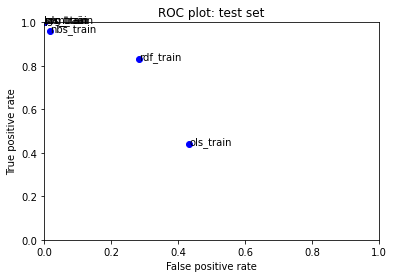

In [113]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

In [63]:
# Looking at reviews based on their classification

In [64]:
ols_predictions = ols.predict(X_train)

In [65]:
# False positives

In [66]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(ols_predictions)):
    if (ols_predictions[i] == 1):
        if (X_raw_train.iloc[i]['sentiment'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['review'])
                print('* * * * * * * * * ')

Examples of false positives:
78
This movie was supposed to have depicted a 'ladie's man' bachelor who was ready and willing to settle down once and for all. However, I did not care for his mission to settle down, because I didn't care for his character. I don't understand what all of these beautiful women saw in him. He had absolutely no class, or charisma. He should've at least had a way about himself that made ladies weak in the knees other than his saxophone playing, but to no avail. Just because he is a musician does not make him sexy. Not to mention, the things he did to get the attention of a married woman he fell in love in a span of five minutes of knowing her were absolutely outrageous and ridiculous. Does this man have any shame what-so-ever? Had he tidied up, and stopped doing and saying stupid things he would have been more attractive as a character, but alas, his character was bland and boring.<br /><br />Gina Gershon's character was unnecessarily British. She could've jus

1157
After having seen the Canadian/Icelandic/British 2004 production of \Beowulf & Grendel,\" which I thought brilliant and stunning, I approached this--the first of 3 newer Beowulf movies due out this year--with trepidation. As soon as I heard \"Viking\" and saw the horned helmets, I groaned. These were Migration Era Swedes and Danes, not Vikings (they came later). And even the Vikings never wore horns on their helmets (horns make it easy for your enemy to knock your helmet off and then brain you). Then there's Hrolfgar's palace, which looks like a set for a movie about Greece or Rome, not 6th-century Denmark. The swords and armor look like props left over from earlier films set in various historic periods. I spotted weapons that might have been used by Crusaders in \"Kingdom of Heaven,\" and one character was even wielding a Windlass Steelcrafts reproduction movie sword from \"Beowulf & Grendel\"! Beyond the basic plot of the original epic poem, the writing was dismal and the acting

3711
I think everyone was quite disappointed with this sci-fi flick. For one thing, it was directed by Tim Burton. Another thing, it's a remake of what is supposed to be a classic. I found it boring, gross, and ridiculous. If you've seen it, you know what I mean. Just about everyone at Imdb say it's crap and boy, are they right! If you haven't, avoid it. It's a snorer. 1 out of 10.
* * * * * * * * * 
3794
STAR RATING: ***** The Works **** Just Misses the Mark *** That Little Bit In Between ** Lagging Behind * The Pits <br /><br />In this debut effort for Nick Park's beloved man and dog, they are forced to fly to the moon when good old Wallace runs out of cheese.<br /><br />As well as being the shortest feature at just 22 minutes, this W/G adventure is also the earliest and it kinda shows. The plasticine animation is a little creaky and funny here, sort of reminiscent of the Mork animation about the little man in the box.<br /><br />Admirable though the craftsmanship behind it is, I've 

5207
After seeing this film I complained to my local cinema about the quality of the sound-track or whether the cinema sound system may be faulty. For at least the first half of the film it is extremely difficult to understand what anyone is saying because of the background 20's music and the scratchiness of the sound-track. I was ready to blame the cinema equipment but not so - it was the Director.<br /><br />I was told the subject of my complaint was an essential part of the making of the film. The music and the sound was supposed to be distorted to create a very disturbing effect within the film. These days, directors will go to many lengths to make their film unique. Unfortunately, no matter where or how you see that film the sound score will be the same.<br /><br />So apart from the historical inaccuracies of this film (which you can find out for yourself elsewhere) the sound-track distortions are in themselves a good reason to give this film a miss. You will only hear the distort

7328
The soul of an ancient mummy is transferred to one of his followers so that he might punish everyone involved in the desecration of his tomb. The soul transference makes the young man age at a tremendous pace until he himself resembles a mummy. One by one, the blood is drained from those involved in the dig.<br /><br />To be as brief as possible, Pharaoh's Curse is quite the lackluster affair. While the movie does present a few good, original ideas (blood sucking mummy's, soul transference, interesting make-up effects, the arm ripping scene, etc.) and a few atmospheric moments, the direction and pace are the very definition of plodding. To make matters even worse, the first 15 of the film's relatively short 66 minute runtime consist of nothing much more than padding. I usually go for these slow moving mummy movies, but Pharaoh's Curse tests even my patients. The cast helps very little. With only one exception (Ziva Rodann is the lone bright spot  wish the movie could have focused

8869
My girlfriend once brought around The Zombie Chronicles for us to watch as a joke. Little did we realize the joke was on her for paying £1 for it. While watching this film I started to come up with things I would rather be doing than watching The Zombie Chronicles. These included:<br /><br />1) Drinking bleach 2) Rubbing sand in my eyes 3) Writing a letter to Brad Sykes and Garrett Clancy 4) Re-enacting the American civil war 5) Tax returns 6) GCSE Maths 7) Sex with an old lady.<br /><br />Garrett Clancy, aka Sgt. Ben Draper wrote this? The guy couldn't even dig a hole properly. The best ting he did was kick a door down (the best part of the film). This was the worst film I have ever seen, and I've seen White Noise: The Light. Never has a film had so many mistakes in it. My girlfriend left it here, so now I live with the shame of owning this piece of crap.<br /><br />News just in: Owen Wilson watched this film and tried to kill himself. Fact.<br /><br />DO NOT WATCH
* * * * * * * 

10738
This is the type of movie where it actually hurts to acknowledge that it really, really sucks. I normally sanctify stuff like this! Early 70's grindhouse flicks with scrumptious sounding titles and a schlocky low-budget atmosphere usually ROCK. \House of Seven Corpses\" appeared to dispose of even more trumps, since the cast is a gathering of great genre veterans (including John Carradine, John Ireland and Faith Domergue) and the filming locations (the titular house, the graveyard) are obviously very expedient for a gloomy tale of terror. The film opens with its absolute greatest and most hauntingly memorable sequences, though sadly enough they're the only ones that qualify as such. The credits are a splendid montage, complete with freakish color-effects and eerie freeze-frames, illustrating how the titular house received its notorious reputation. The last seven owners were mysteriously murdered here and the credits montage gleefully exhibits their final moments. Someone falls do

12982
Here's how you do it: Believe in God and repent for your sins. Then things should turn around within the next day or so. <br /><br />Until the last fifteen minutes, this movie just plays as a bad recap of a drunk's crappy life. His mom dies. His stepmom's a b_tch. His dad dies. He drinks. He gets married. He has kids. He drinks some more. His wife gets mad. He disappoints his kids. The wife threatens to leave. He calls up a reverend late night b/c he wants to kill himself. Then after the recap happens, that's when we get the \Left Behind\"-like subtle message.<br /><br />\"He needed a paycheck\". This is the phrase I had to repeat over and over once credits started to roll so I wouldn't lose my respect for Madsen.<br /><br />Madsen drops to his knees and begs Christ's forgiveness. Once he does, he walks outside and actually says that he sees the world in a different way. He tells his wife that he's found God and that's good enough for her. Flip scene four months and the wife is t

14185
What The Bleep Do We Know is a deluded and haphazard look at the mysteries of the universe. We are presented with a parade of apparent experts (none of whom are named) who ramble and pontificate in a thoroughly unscientific manner. Their interviews are chopped up into aggravatingly small segments and dispersed throughout some flashy cgi and banal mini-plots.<br /><br />The film pilfers themes from science, philosophy, theology and politics, minces them together without any regard for accuracy, and then somehow extracts a few prosaic and absurd conclusions. We are led to believe that quantum physics is telling us the purpose of our existence, and any other difficult to answer question the film-makers would like to point their finger at.<br /><br />It is riddled errors and logical non-sequiturs. How did we start at quantum mechanics and end up with this pseudo-scientific spirituality and mysticism? It's like saying 'two plus two equals four, therefore I can move objects with my min

16391
I'm not sure if users ought to be allowed to review films after only sitting through half, but I'm afraid I just couldn't stand another minute.<br /><br />If this abject excuse for a film doesn't have the late, great GP spinning like a wheel in his grave, then I doubt anything will.<br /><br />The excellent review above 'Not a film for Parsons fans' sums up most of my feelings. How dare a (second rate) director and writer attempt something to which they're so clearly incapable of delivering. What were they thinking? Where to start?<br /><br />THE SCRIPT: I thought I'd be getting a slice of bittersweet Americana. What I got was poorly executed slapstick with no cliché left unturned. Stupid hippy? Check. Stupid fat cop? Check. Awful plot contrivances? Check. Embarrassingly written female characters? Double check. Total disregard for the story which you're trying to portray? Check.<br /><br />After a while, you realize that what you're watching is a soap and not a very well written 

17629
We all knew even before it aired, the Ron Moore mini-series is no Battlestar Galactica. That's fine. It just means it must stand on its own. It can't lean on Battlestar Galactica. If it's any good, it's good on it's own merits, and Ron Moore has something to be proud of. If reports are true, this is what Moore wanted. However, if his mini-series rots, he has shamed all the excellent actors that performed on-screen, not to mention the myriad off-screen personnel. And this is what he's done.<br /><br />Yes, this mini-series is no remake. I wouldn't even call it a re-imagining. It's a new production, inspired by Battlestar Galactica. It does not take place in the Galactica universe, with the same places and jargon and technology. It doesn't tell of the Galactica's search for the thirteenth tribe. Nor does it rely on the legends and mysteries that underpinned Galactica. Ron Moore's mini-series is a space-opera, action flick with a ceremonial nod to Battlestar Galactica.<br /><br />Ma

19831
this is without a doubt the worst most idiotic horrible piece o' crap i have ever watched.<br /><br />this movies plot is that some guy goes crazy and dresses up as santa claus and kills people BECAUSE he saw his mother give his father oral sex while he was dressed as santa clause. THAT IS WHY HE WENT INSANE? is it just me or is that the worst damn reason for someone to go insane like EVER? and that's not the only thing. i'm being serious when I say NOTHING HAPPENS IN THIS DAMN MOVIE. nothing until like 1 hour and 15 minutes of it have gone by.<br /><br />there's an entire friggin scene where he glues a friggin santa beard on to him. IT'S A FRIGGIN MINUTE LONG. WHO THE HELL WANTS TO SEE THAT? however i must say the ending of this movie made me crap myself laughing at it. so if you see this movie on TV or something come back in like 1 hour and 20 minutes just to watch without a doubt the worst ending in all of cinematic history. and i'm serious about that.<br /><br />it's not even

In [67]:
# Look at performace on the test set
# Model ordinary least squares

In [68]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)


{'Pos': 2498, 'Neg': 2502, 'TP': 1266, 'TN': 1195, 'FP': 1307, 'FN': 1232, 'Accuracy': 0.4922, 'Precision': 0.49203264671589586, 'Recall': 0.5068054443554844, 'desc': 'ols_test'}


In [69]:
# Model SVM linear

In [70]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2093, 'TN': 2063, 'FP': 439, 'FN': 405, 'Accuracy': 0.8312, 'Precision': 0.8266192733017378, 'Recall': 0.8378702962369896, 'desc': 'svm_test'}


In [71]:
# Model logistic regression

In [72]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2081, 'TN': 2048, 'FP': 454, 'FN': 417, 'Accuracy': 0.8258, 'Precision': 0.8209072978303747, 'Recall': 0.83306645316253, 'desc': 'lgs_test'}


In [73]:
# Model naive Bayes

In [74]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 1802, 'TN': 1880, 'FP': 622, 'FN': 696, 'Accuracy': 0.7364, 'Precision': 0.7433993399339934, 'Recall': 0.7213771016813451, 'desc': 'nbs_test'}


In [75]:
# Model precertron

In [76]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2079, 'TN': 2075, 'FP': 427, 'FN': 419, 'Accuracy': 0.8308, 'Precision': 0.8296089385474861, 'Recall': 0.8322658126501201, 'desc': 'prc_test'}


In [77]:
# Model Ridge regression classifier

In [78]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2070, 'TN': 1990, 'FP': 512, 'FN': 428, 'Accuracy': 0.812, 'Precision': 0.801704105344694, 'Recall': 0.8286629303442754, 'desc': 'rdg_test'}


In [79]:
# Random Forest classifier

In [80]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 2498, 'Neg': 2502, 'TP': 2043, 'TN': 1784, 'FP': 718, 'FN': 455, 'Accuracy': 0.7654, 'Precision': 0.7399492937341543, 'Recall': 0.8178542834267414, 'desc': 'rdf_test'}


In [81]:
# ROC plot to compare performance of various models and fits

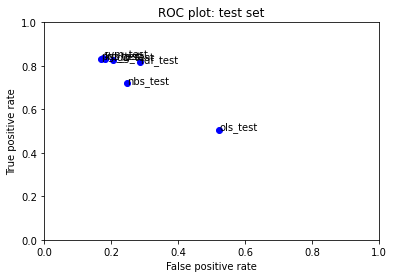

In [120]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()